In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive
drive.mount('/content/drive')
BASE_PATH = "/content/drive/MyDrive/Project/"

#Load image paths
train_txt_path = os.path.join(BASE_PATH, "Category and Attribute Prediction Benchmark/Anno_fine/train.txt")
train_cate_path = os.path.join(BASE_PATH, "Category and Attribute Prediction Benchmark/Anno_fine/train_cate.txt")
train_attr_path = os.path.join(BASE_PATH, "Category and Attribute Prediction Benchmark/Anno_fine/train_attr.txt")

with open(train_txt_path, "r") as f:
    image_paths = [line.strip() for line in f.readlines()]

with open(train_cate_path, "r") as f:
    category_labels = np.array([int(line.strip()) for line in f.readlines()])

with open(train_attr_path, "r") as f:
    attribute_labels = np.array([[int(x) for x in line.split()] for line in f.readlines()])

#Only the first 100 records
image_paths = image_paths[:100]
category_labels = category_labels[:100]
attribute_labels = attribute_labels[:100]



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Ensure label consistency
assert len(image_paths) == len(category_labels) == len(attribute_labels), "Mismatch in data lengths"

#Fix: Convert category labels to zero-based indexing**
unique_categories = sorted(set(category_labels))  # Get sorted unique categories
category_to_index = {cat: idx for idx, cat in enumerate(unique_categories)}  # Create mapping

#Applying mapping to category labels
category_labels = np.array([category_to_index[cat] for cat in category_labels])

#Get correct number of categories and attributes
num_categories = len(unique_categories)  # Now correctly set
num_attributes = attribute_labels.shape[1]

print(f"Unique Categories: {unique_categories}")
print(f"Max category label after remapping: {np.max(category_labels)}")
print(f"Expected num_categories: {num_categories}")

#Function to load and preprocess images
def load_and_preprocess_image(path, target_width=224, target_height=300):
    try:
        img = load_img(os.path.join(BASE_PATH, path), target_size=(target_height, target_width))  # Resize image
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        return img_array
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# Load images
images = [load_and_preprocess_image(path) for path in image_paths]
images = np.array([img for img in images if img is not None])  # Remove failed loads

# Ensure dataset consistency
category_labels = category_labels[:len(images)]
attribute_labels = attribute_labels[:len(images)]

#Model architecture
input_layer = Input(shape=(300, 224, 3))

#Feature extraction layers (CNN)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

#Classification Head (for categories)
category_output = Dense(128, activation="relu")(x)
category_output = Dropout(0.5)(category_output)
category_output = Dense(num_categories, activation="softmax", name="category_output")(category_output)  # FIXED num_categories

#Attribute Head (for multi-label classification)
attribute_output = Dense(128, activation="relu")(x)
attribute_output = Dropout(0.5)(attribute_output)
attribute_output = Dense(num_attributes, activation="sigmoid", name="attribute_output")(attribute_output)

#Defining the model
model = Model(inputs=input_layer, outputs=[category_output, attribute_output])

#Compiling the model
model.compile(
    optimizer="adam",
    loss={"category_output": "sparse_categorical_crossentropy", "attribute_output": "binary_crossentropy"},
    metrics={"category_output": "accuracy", "attribute_output": "accuracy"}
)

#Training the model w/first 100 records
history = model.fit(images, {"category_output": category_labels, "attribute_output": attribute_labels},epochs=10,batch_size=32)

Unique Categories: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Max category label after remapping: 21
Expected num_categories: 22
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - attribute_output_accuracy: 0.0155 - attribute_output_loss: 0.8850 - category_output_accuracy: 0.0520 - category_output_loss: 5.5422 - loss: 6.5913
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - attribute_output_accuracy: 0.1209 - attribute_output_loss: 0.6256 - category_output_accuracy: 0.1056 - category_output_loss: 3.1415 - loss: 3.7819
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - attribute_output_accuracy: 0.1265 - attribute_output_loss: 0.5473 - category_output_accuracy: 0.2872 - category_output_loss: 2.9622 - loss: 3.4632
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - attribute_output_accuracy: 0.0061 - attribute_output_loss: 0.5180 - category_output_accuracy: 0.2540 - category_output_loss: 2.7199 - loss: 3.2741
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step

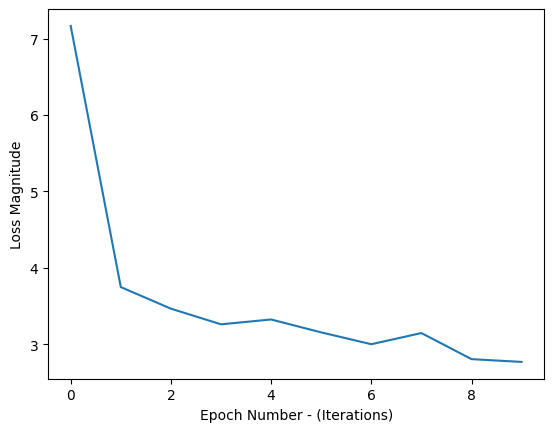

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number - (Iterations)')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['loss'])

In [ ]:
#Predicting the model
def predict_image(model, image_path):
    img = load_and_preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    category_pred, attr_pred = model.predict(img)
    print(f"Predicted Category: {np.argmax(category_pred)}")
    print(f"Predicted Attributes: {np.round(attr_pred)}")

predict_image(model, "img/Sweet_Crochet_Blouse/img_00000070.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
Predicted Category: 18
Predicted Attributes: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]]
